In [22]:
import sys

sys.path.append("..")

import yaml
import numpy as np
import matplotlib.pyplot as plt
from src.environments import ea

# RL4AA Tutorial -- Part 1

Goal: Solve the ARES Experimental Area tuning problem in a standard setting.

In [2]:
# Create the Environment
# TODO: Move this part to a utility function later

from gymnasium.wrappers import TimeLimit, FlattenObservation, RescaleAction
from src.wrappers import RecordEpisode, RescaleObservation


def make_eval_env(config: dict):
    wrapper_config = config["env_wrapper"]
    env = ea.TransverseTuning(**config["env"])

    env = TimeLimit(env, max_episode_steps=wrapper_config["max_episode_steps"])
    env = RecordEpisode(env)
    if wrapper_config["normalize_observation"]:
        env = RescaleObservation(env, 0, 1)
    if wrapper_config["rescale_action"]:
        env = RescaleAction(env, -1, 1)
    env = FlattenObservation(env)
    return env

In [3]:
config = yaml.safe_load(open("../config/ea_eval_config.yaml", "r"))

env = make_eval_env(config)

In [4]:
env.reset()

(array([-1.5692047 ,  1.646749  ,  0.5564025 ,  0.54640764,  0.8222494 ,
         0.13888127,  0.4423622 ,  0.1953454 ,  0.17270067,  0.5       ,
         0.        ,  0.5       ,  0.        ], dtype=float32),
 {'binning': array(1),
  'is_on_screen': False,
  'pixel_size': array([3.3198e-06, 2.4469e-06], dtype=float32),
  'screen_resolution': array([2448., 2040.]),
  'magnet_names': ['AREAMQZM1',
   'AREAMQZM2',
   'AREAMCVM1',
   'AREAMQZM3',
   'AREAMCHM1'],
  'screen_name': 'AREABSCR1',
  'beam_reward': None,
  'on_screen_reward': None,
  'magnet_change_reward': None,
  'backend_info': {'incoming_beam': array([ 8.9221248e+07,  6.2942225e-04, -7.7964280e-05, -2.2459489e-04,
          -7.9526224e-05,  4.7598398e-04,  4.6226640e-05,  4.0731969e-04,
           1.3777382e-05,  3.7240861e-05,  5.5650092e-04], dtype=float32),
   'misalignments': array([-8.6626977e-05,  1.3867175e-06,  3.1859563e-05, -1.2523483e-05,
           5.5042485e-05, -4.3142711e-05,  6.9185618e-05, -2.3745260e-05],


In [5]:
env.unwrapped.get_beam_difference(metric="mae")

0.0032221857181866653

## The EA Tuning Task Setup

Observation:


## Trying to solve the EA problem

Implement a controller or optimization method, that can bring the observed electron beam $\bm{b}$ to the target beam parameters $\bm{b}'$.

The difference between the beam parameters can be characterized by the mean absolute error (MAE):

$$
d_\text{MAE} (\bm{b}, \bm{b}') = \frac{1}{4} \sum_{i=1}^{4} |\bm{b}_i - \bm{b}'_i|
$$

The algorithm is allowed to interact with the environment for in total $T$ steps. ($T=200$ in this example)

The performance of the method will be evaluated by the following metrics:

- Best MAE achieved by the method $\min d_i, i=1,\dots, T$
- Cumulated MAE differences over the episode $\sum_{i=1}^{T} d_i$

In [31]:
# Here we provide the baseline Nelder-Mead Simplex Method
from scipy.optimize import minimize


def objective(x):
    env.step(x)
    return env.unwrapped.get_beam_difference(metric="mae")


# Reset the Environment
obs, _ = env.reset()

x0 = obs[4:9]

res = minimize(
    objective,
    x0,
    method="nelder-mead",
    options={
        "xatol": 1e-8,
        "disp": True,
        "maxfev": config["env_wrapper"][
            "max_episode_steps"
        ],  # Maximum number of function evaluations
    },
)

/var/folders/35/tl4qn9hx1c59cv7hmzsrrbd00000gn/T/ipykernel_4817/513448258.py:13: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


## Look into the result

TODO: Move the following part in a utility function and hide from participants

Minimum MAE:                0.197 mm
Sum of MAE over all steps:  164.920 mm


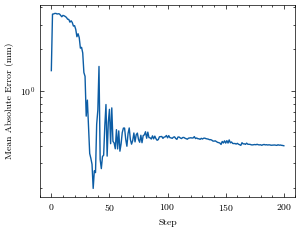

In [39]:
observations = env.get_wrapper_attr("observations")

maes = np.array([np.mean(obs["beam"] - obs["target"]) for obs in observations])

plt.plot(maes * 1000)
# set y to logscale
plt.yscale("log")
plt.ylabel("Mean Absolute Error (mm)")
plt.xlabel("Step")

print(f"Minimum MAE:                {min(maes) * 1000:.3f}  mm")
print(f"Sum of MAE over all steps:  {np.sum(maes) * 1000:.3f} mm")